In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Data Preprocessing:

In [2]:
EWA=pd.read_excel('EastWestAirlines.xlsx',sheet_name='data')
EWA.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
# rename the columns 
EWA.rename(columns={'ID#':'cum_ID','cc1_miles':'FFcc_miles','cc2_miles':'Rcc_miles','cc3_miles':'SBcc_miles','Award?':'Award'},
inplace=True)

In [4]:
EWA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   cum_ID             3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   FFcc_miles         3999 non-null   int64
 4   Rcc_miles          3999 non-null   int64
 5   SBcc_miles         3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award              3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [5]:
# Droping cum_id column
EWA_1=EWA.drop('cum_ID',axis=1)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


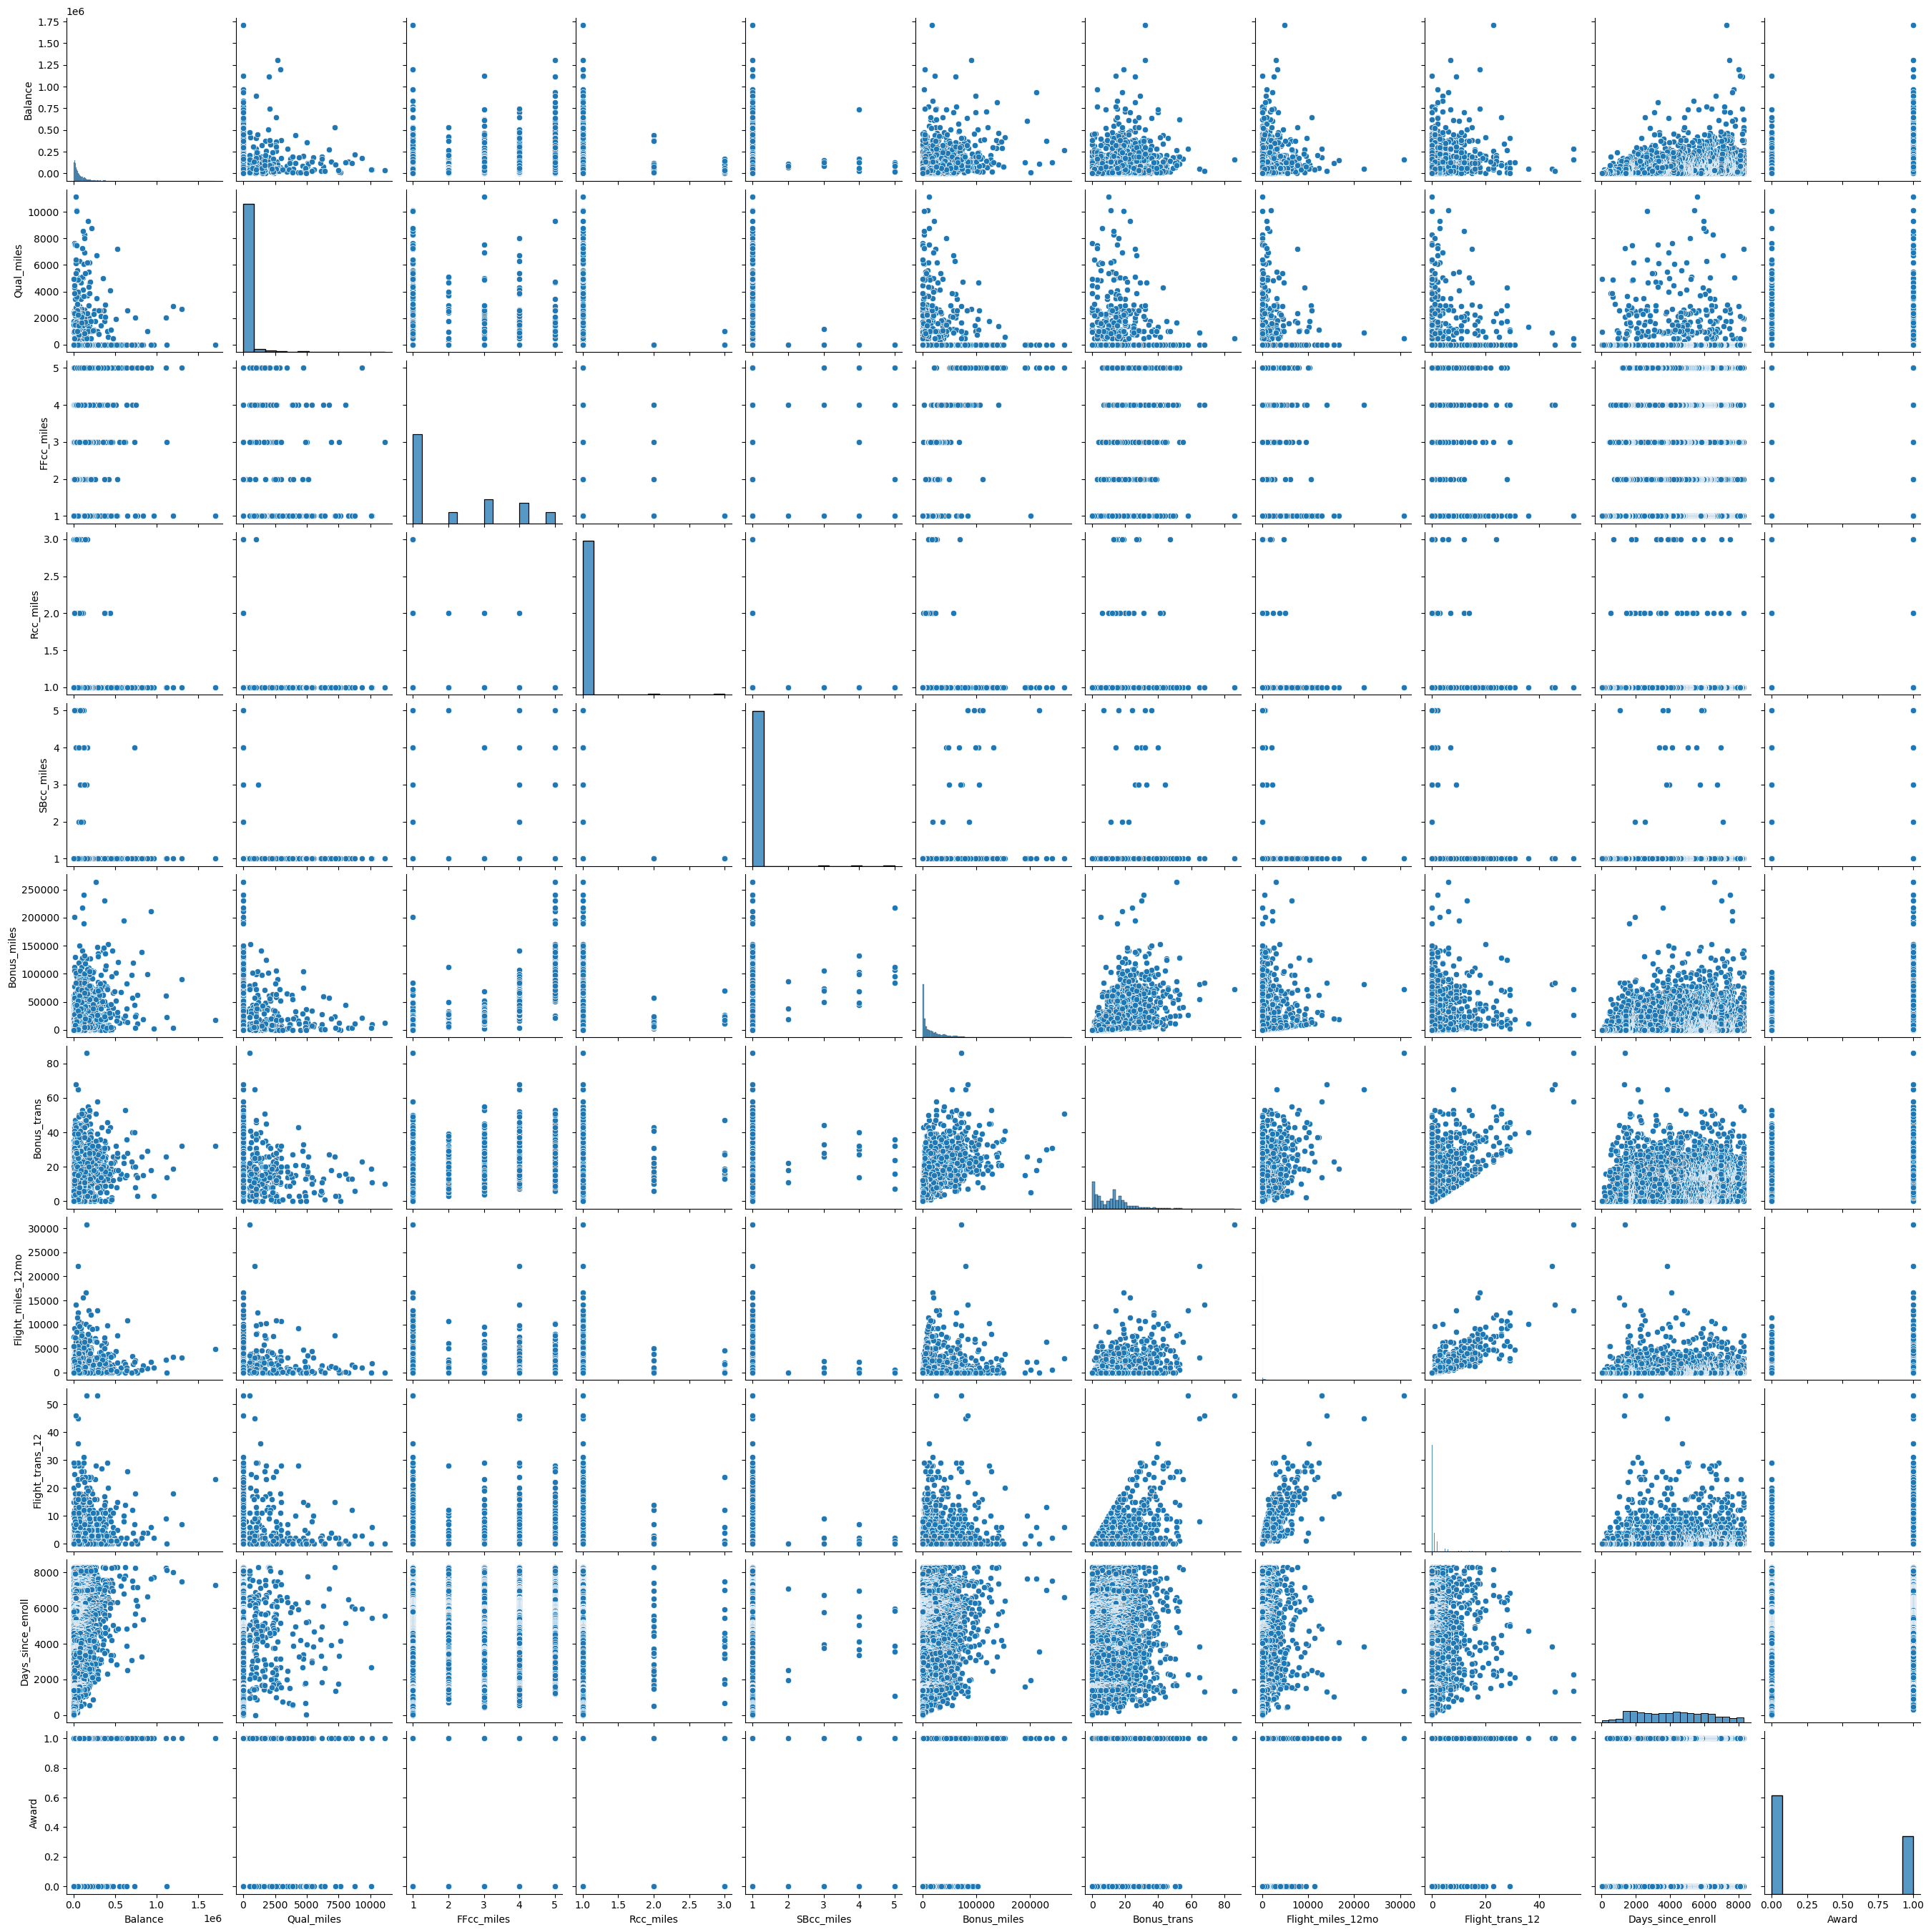

In [29]:
sns.pairplot(EWA_1)

In [6]:
# Standardising the data as euclidean distance is influenced by scaling
std=StandardScaler()
EWA_std=std.fit_transform(EWA_1)
EWA_std=pd.DataFrame(EWA_std,columns=EWA_1.columns)

# Implementing Clustering Algorithms:

# KMeans clustering

In [7]:
wcss=[]
k=[]
for i in range(1,11):
    kmean=KMeans(n_clusters=i,n_init=10)
    kmean.fit(EWA_std)
    wcss.append(kmean.inertia_)
    k.append(i)

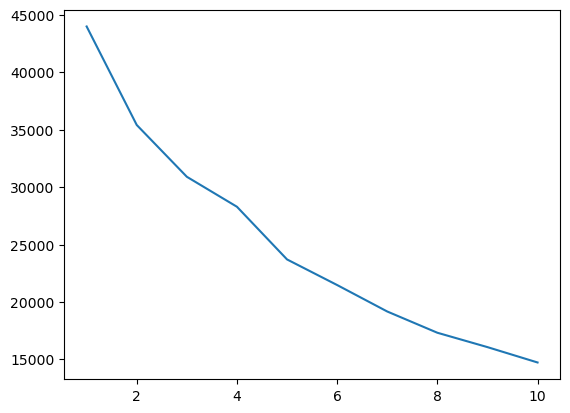

In [8]:
# Scree plot or Elbow plot
x=np.array(k)
y=np.array(wcss)
plt.plot(x,y)
plt.show()

In [9]:
# from the elbow graph it is clear to get 4 clusters
km=KMeans(n_clusters=4,n_init=10)
km.fit(EWA_std)

KMeans(n_clusters=4, n_init=10)

In [10]:
labels=km.labels_

In [11]:
ewa_k=EWA_1.copy()
ewa_k['label']=labels

In [12]:
ewa_k.label.value_counts()

label
0    2550
1    1274
2     160
3      15
Name: count, dtype: int64

In [13]:
# Evaluation and Performance Metrics:
ss=silhouette_score(EWA_std,labels)
ss

0.30964560112780576

In [14]:
ewa_k.groupby(['label','Award']).agg('mean')

Balance  Qual_miles  FFcc_miles  Rcc_miles  SBcc_miles  \
label Award                                                                 
0     0       42230.166503   82.359037    1.251965   1.016699    1.000491   
      1       50338.000000  155.834630    1.114786   1.029183    1.000000   
1     0      135672.197753  109.062921    3.768539   1.002247    1.002247   
      1      107265.483715  182.895054    3.664656   1.002413    1.001206   
2     0       92766.433333  145.566667    1.566667   1.000000    1.000000   
      1      217894.076923  944.846154    2.307692   1.046154    1.000000   
3     0      208342.857143    0.000000    3.000000   1.000000    3.857143   
      1       76565.125000  147.750000    3.875000   1.000000    4.250000   

               Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
label Award                                                                   
0     0        4344.959234     6.866896         153.460216         0.463163   
      1        6194.745136     7.217899         392.217899         1.270428   
1     0       35906.258427    18.631461         231.892135         0.647191   
      1       41062.769602    18.841978         410.605549         1.232811   
2     0       14732.233333    19.033333        5045.566667        13.466667   
      1       35858.446154    29.246154        5562.823077        16.607692   
3     0       69533.142857    25.571429         400.000000         1.142857   
      1      115273.250000    30.250000         600.000000         2.000000   

             Days_since_enroll  
label Award                     
0     0            3593.849214  
      1            4103.153696  
1     0            4859.366292  
      1            4896.322075  
2     0            3757.400000  
      1            4927.861538  
3     0            4026.428571  
      1            5127.875000

# DBSCAN

In [15]:
# first calculate best epsilon value using K-distance graph
neigh= NearestNeighbors(n_neighbors=4)
nbrs=neigh.fit(EWA_std)
distances,indices=nbrs.kneighbors(EWA_std)
distances = np.sort(distances, axis=0)

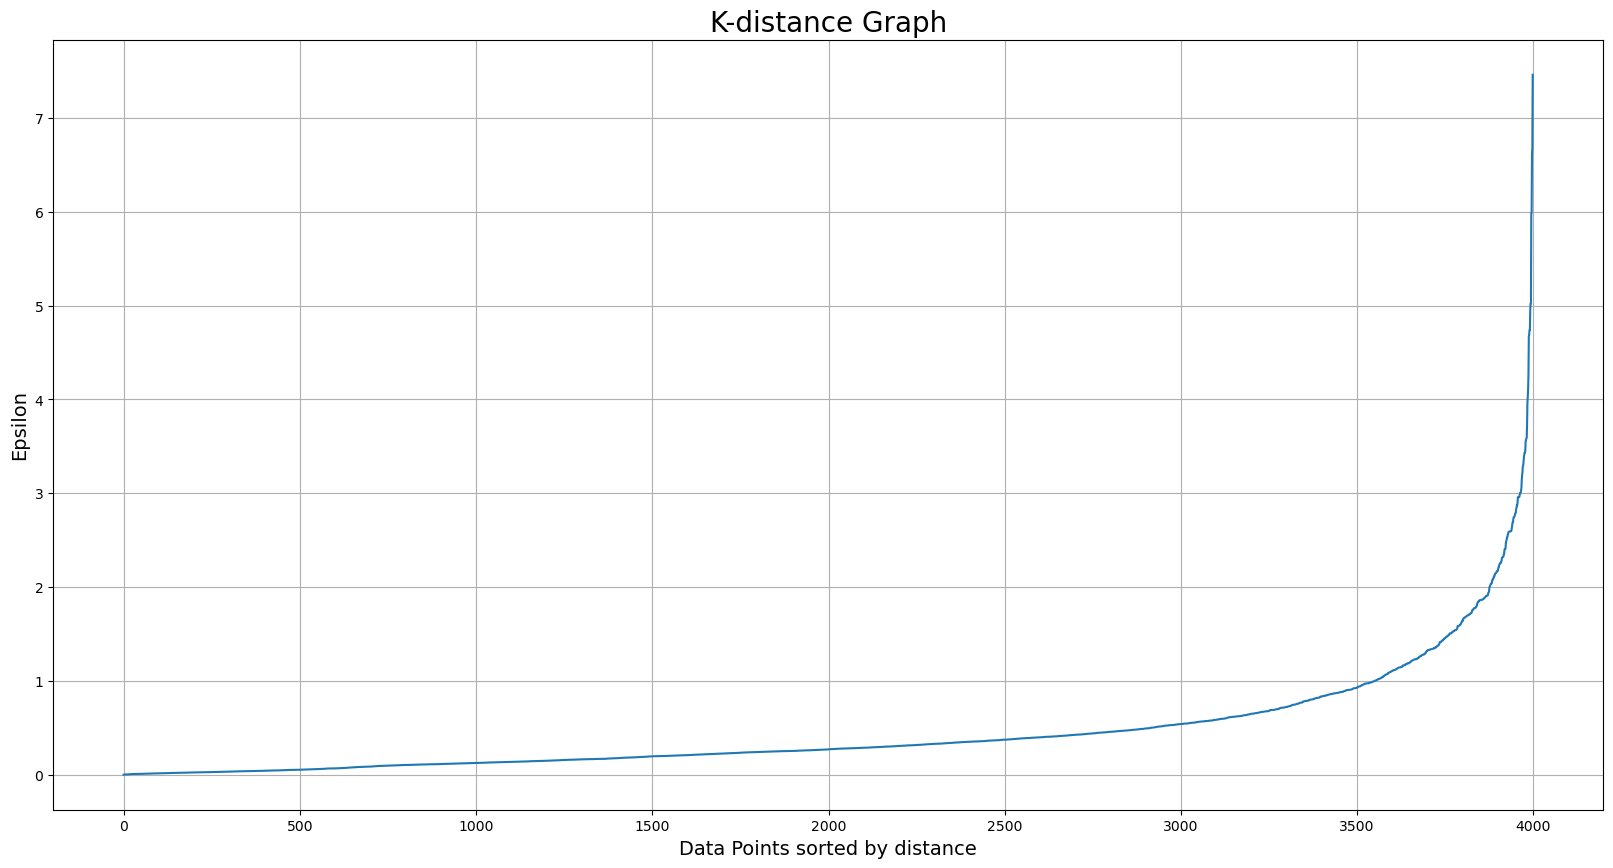

In [16]:
# Plotting K-distance Graph
distance = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distance)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.grid()
plt.show()

In [17]:
# take epsilon value = 1.5 
dbscan_opt=DBSCAN(eps=1.5,min_samples=6) # i checked the min_sampels from 4 ,5,6
dbscan_opt.fit(EWA_std)

DBSCAN(eps=1.5, min_samples=6)

In [18]:
ewa=EWA_1.copy()
ewa['DBSCAN_opt_labels']=dbscan_opt.labels_
ewa['DBSCAN_opt_labels'].value_counts()

DBSCAN_opt_labels
 0    2410
 1    1241
-1     325
 2      15
 3       8
Name: count, dtype: int64

In [19]:
# Evaluation and Performance Metrics:
s=silhouette_score(EWA_std,dbscan_opt.labels_)
s

0.25262647778840513

In [80]:
ewa.groupby(['DBSCAN_opt_labels','Award']).agg('mean')

Balance   Qual_miles  FFcc_miles  Rcc_miles  \
DBSCAN_opt_labels Award                                                      
-1                0      158556.470588  1765.364706    2.482353   1.047059   
                  1      228312.304167  1202.925000    2.787500   1.095833   
 0                0       56534.562241    29.264315    1.684647   1.000000   
 1                1       71668.506044    54.012087    2.637389   1.000000   
 2                0       38556.733333     0.000000    1.000000   2.000000   
 3                0       36524.250000     0.000000    1.000000   3.000000   

                         SBcc_miles   Bonus_miles  Bonus_trans  \
DBSCAN_opt_labels Award                                          
-1                0        1.258824  27964.282353    19.800000   
                  1        1.112500  50156.108333    26.504167   
 0                0        1.000000   9592.504564     8.725726   
 1                1        1.000000  24795.691378    13.709106   
 2                0        1.000000   8951.533333    12.933333   
 3                0        1.000000  15518.500000    14.500000   

                         Flight_miles_12mo  Flight_trans_12  Days_since_enroll  
DBSCAN_opt_labels Award                                                         
-1                0            1801.082353         4.882353        4391.882353  
                  1            3333.208333         9.862500        4934.800000  
 0                0             172.370124         0.506224        3805.310788  
 1                1             378.717969         1.195004        4565.161160  
 2                0              60.000000         0.400000        3390.400000  
 3                0              50.000000         0.250000        3179.625000

# Agglomarative clustering

In [22]:
dm=sch.linkage(EWA_std,method='complete',metric='mahalanobis')

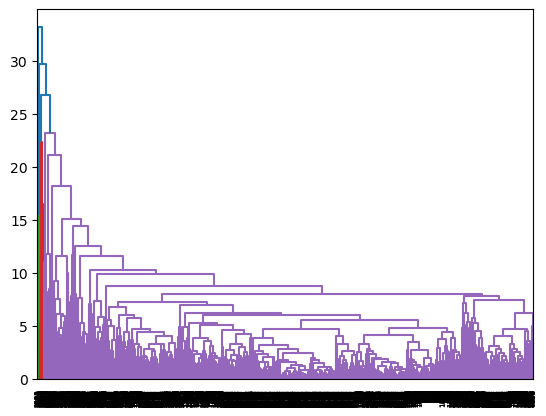

In [23]:
dendo=sch.dendrogram(dm)

In [25]:
hc = AgglomerativeClustering(n_clusters=4,metric='mahalanobis',linkage='complete')
hc.fit(EWA_std)

AgglomerativeClustering(linkage='complete', metric='mahalanobis', n_clusters=4)

In [27]:
ews_hc=EWA_1.copy()

In [28]:
ews_hc['labels']=hc.labels_

In [29]:
ews_hc.labels.value_counts()

labels
0    3944
1      33
2      15
3       7
Name: count, dtype: int64

In [30]:
ews_hc.groupby(['labels','Award']).agg('mean')

Balance  Qual_miles  FFcc_miles  Rcc_miles  SBcc_miles  \
labels Award                                                                 
0      0       58335.556487   88.057086    1.699800   1.013972    1.000798   
       1       86429.630299  236.608756    2.652536   1.015983    1.000695   
1      0      586115.200000    0.000000    2.800000   1.000000    1.000000   
       1      640764.857143  452.892857    2.892857   1.000000    1.000000   
2      0      208342.857143    0.000000    3.000000   1.000000    3.857143   
       1       76565.125000  147.750000    3.875000   1.000000    4.250000   
3      0       76595.000000    0.000000    1.000000   1.000000    1.000000   
       1      134899.000000  231.333333    2.166667   1.000000    1.000000   

                Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
labels Award                                                                   
0      0       10043.215569     9.081038         220.469860         0.636327   
       1       28022.018763    15.371786         745.128562         2.287005   
1      0       19551.400000    18.600000        1030.000000         8.000000   
       1       45697.642857    28.107143        3027.285714        14.178571   
2      0       69533.142857    25.571429         400.000000         1.142857   
       1      115273.250000    30.250000         600.000000         2.000000   
3      0       10577.000000     2.000000        9577.000000         1.000000   
       1       47252.333333    37.500000       18025.833333        24.333333   

              Days_since_enroll  
labels Award                     
0      0            3816.897804  
       1            4604.503127  
1      0            5874.600000  
       1            5847.142857  
2      0            4026.428571  
       1            5127.875000  
3      0            1515.000000  
       1            3182.333333